In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"{lastdate}")

('2017-08-23',)


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdatedt= dt.datetime.strptime(lastdate[0], '%Y-%m-%d')


In [18]:
# Calculate the date one year from the last date in data set.
datequery = dt.date(lastdatedt.year -1, lastdatedt.month, lastdatedt.day)
datequery

datetime.date(2016, 8, 23)

In [20]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = [Measurement.date, Measurement.prcp]
queryresult = session.query(*prcp_query).filter(Measurement.date >= datequery).all()

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(queryresult, columns=['Date', 'Precipitation'])
#Drop NAs
prcp_df = prcp_df.dropna(how='any')
prcp_df = prcp_df.set_index("Date")
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


In [26]:
# Sort the dataframe by date
prcp_df = prcp_df.sort_values(["Date"], ascending=True)
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


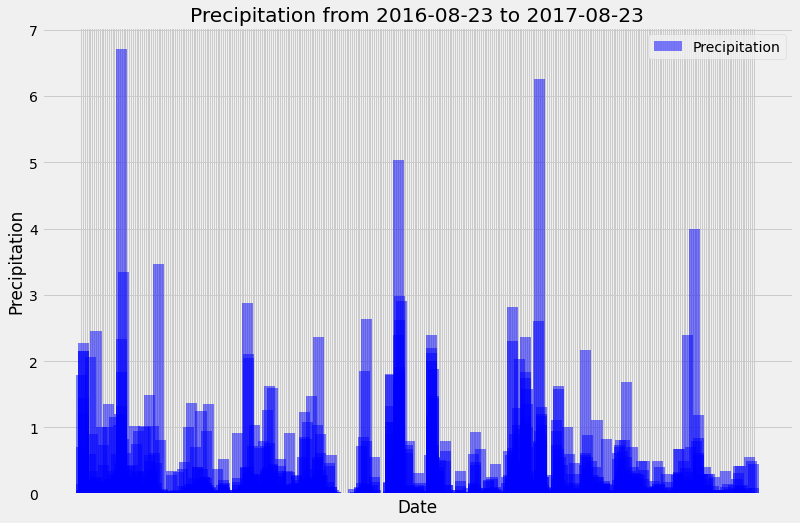

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
xaxis=prcp_df.index.tolist()
yaxis=prcp_df['Precipitation'].tolist()

plt.figure(figsize=(12,8))
plt.bar(xaxis,yaxis,width=6, color='blue', alpha = 0.5, label='Precipitation')
plt.tick_params(
    labelbottom = False
)

plt.title(f"Precipitation from {datequery} to {lastdate[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()


In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [33]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations= [Measurement.station, func.count(Measurement.id)]
active = session.query(*stations).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
topstationdata = session.query(*temps).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
topstationdata

(54.0, 85.0, 71.66378066378067)

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempquery = session.query(Measurement.tobs).filter(Measurement.station == active[0][0]).\
    filter(Measurement.date >= datequery).all()
temperatures = list(np.ravel(tempquery))

topstation= [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
tempquery = session.query(*topstation).all()
stations_desc = pd.DataFrame(tempquery, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationcode = stations_desc.loc[stations_desc["Station"]== active[0][0], "Name"].tolist()[0]

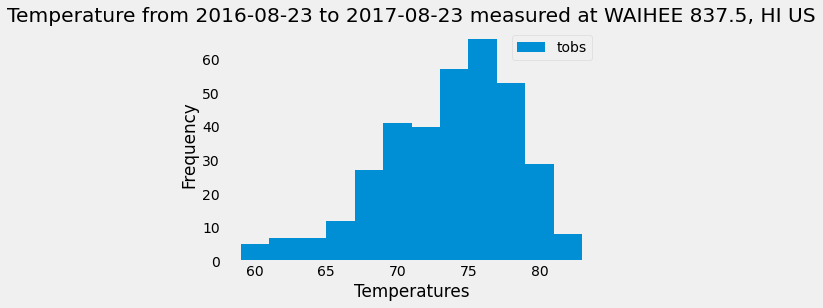

In [37]:
#Plot data in histogram
plt.hist(temperatures, bins=12, rwidth=1.0, label='tobs')
plt.grid(axis='both', alpha = 0.75)
plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.title(f"Temperature from {datequery} to {lastdate[0]} measured at {stationcode}")
plt.legend()

# Close session

In [ ]:
# Close Session
session.close()